In [1]:
import math 
import numpy as np
import pandas as pd
import sympy as sym
from scipy import linalg

points = np.array([[43.307806698283087599, 31.191150598782652281, 0.072183457336111922],
    [16.112075826671009793, 5.837189083843114190, 0.074712046178756722],
    [36.704811945885801094, -69.561000795830508991, 0.076653979260927388],
    [83.912265297915908491, -16.764756317606547498, 0.073054359027073038]])
C = 299792458

In [2]:
def distance(time):
    return C*time

def polar2cart(lat, long, alt):
    x = alt * math.cos(math.radians(lat)) * math.cos(math.radians(long))
    y = alt * math.cos(math.radians(lat)) * math.sin(math.radians(long))
    z = alt * math.sin(math.radians(lat))
    return x, y, z

def cart2polar(x, y, z, d):
    alt = math.sqrt(x**2 + y**2 + z**2)
    lat = math.asin(z/ alt)
    long = math.atan(y/x)
    return math.degrees(lat), math.degrees(long), alt, d

shpdf = pd.DataFrame(points,columns=['Latitude','Longitude','Time'])
shpdf["Distance"] = distance(shpdf["Time"])
print(shpdf)

    Latitude  Longitude      Time      Distance
0  43.307807  31.191151  0.072183  2.164006e+07
1  16.112076   5.837189  0.074712  2.239811e+07
2  36.704812 -69.561001  0.076654  2.298028e+07
3  83.912265 -16.764756  0.073054  2.190115e+07


# Define a matrix of x, y, z, d for each satellite: $[x, y, z, distance]$

In [3]:
#Change satellites into Cartesian coordinates
cart = []
for point in points:
    [lat, long, t] = point
    dist = distance(t)
    alt = 20200000 + 6371000
    x, y, z = polar2cart(lat, long, alt)
    cart.append([x, y, z, dist])

#Create a matrix for satellite x, y, z points and distance to my location
satellites = np.array(cart)
print(satellites)

[[ 16540157.49473261  10013584.13136177  18225514.09133856
   21640056.10173113]
 [ 25394947.83882174   2596179.05174895   7373908.0272799
   22398107.96613899]
 [  7439096.08345129 -19961528.40073888  15881286.92416565
   22980284.85811444]
 [  2698118.38793887   -812799.35743412  26421157.34348556
   21901145.86034071]]


# Define a matrix for location x, y, z, b guesses: $\mu_{n-1}$

In [4]:
#Guess your location: UCD Belfield
lat_guess = 53.307812
long_guess = -6.222284
alt_guess = 6371000
b_guess = 10

# Create a matrix for mu(n-1) guesses 
def mu_matrix(x, y, z, b):
    guess = np.array([x, y, z, b])
    return guess

xi, yi, zi = polar2cart(lat_guess, long_guess, alt_guess)
initial_guesses = mu_matrix(xi, yi, zi, b_guess)

# Define a matrix of functions for each satellite: $F(\mu_{n-1}) = [f_1, f_2, f_3, f_4]^T$

In [5]:
#Define the functions for each satellite
def get_function(satellite, *guesses):
    xp, yp, zp, d = np.array(satellite)
    x_guess, y_guess, z_guess, b_guess = mu_matrix(*guesses)
    return (np.sqrt((x_guess-xp)**2 + (y_guess-yp)**2 + (z_guess-zp)**2)) + b_guess - d


#Create a matrix of all satellite functions.
def F(*guesses):
    sat_functions = []
    for sat in satellites:
        sat_functions.append(get_function(sat, *guesses))
    function_array = np.array(sat_functions)
    return (function_array.transpose())

# Define the Jacobian Matrix: $J^{}$

In [6]:
#Define a function that returns the derivative for x, y or z
def derivative(guess, value, xp, yp, zp, *guesses):
        x_guess, y_guess, z_guess, b_guess = mu_matrix(*guesses)
        return (guess-value) / (np.sqrt((x_guess-xp)**2 + (y_guess-yp)**2 + (z_guess-zp)**2))

#Make a Jacobian Matrix
def J(*guesses):
    x_guess, y_guess, z_guess, b_guess = mu_matrix(*guesses)
    j_list = []
    for sat in satellites:
        xp, yp, zp, dist = sat
        derv_x = derivative(x_guess, xp, xp, yp, zp, *guesses)
        derv_y = derivative(y_guess, yp, xp, yp, zp, *guesses)
        derv_z = derivative(z_guess, zp, xp, yp, zp, *guesses)
        derv_b = 1
        j_list.append([derv_x, derv_y, derv_z, derv_b])
    return np.array(j_list)

# Find Location using equation: $\mu_n = \mu_{n-1} - J^{-1}(\mu_{n-1})F(\mu_{n-1})$

In [7]:
def get_location(*guesses):
    mu = mu_matrix(*guesses).transpose()
    jacobian = J(*mu)
    function = F(*mu)
    location = mu - np.linalg.solve(jacobian, function)
    return location

#Continue to update guess with new location until location converges 

In [8]:
#define a function to change initial guess and number of runs
def run_algorithm(initial_guess, number):
    i = 0
    guess = initial_guess
    #Update guess 100 times until precise location is found
    while i<number:
        position = get_location(*guess)
        guess = position
        i+=1
    #change from cartesian to polar coordinates
    return cart2polar(*position)

Print function to output location in correct format 

In [9]:
def print_location(location):
    lat, long = location[0], location[1]
    elevation = location[-2] - 6371000
    offset = (location[-1]/C)*1000000
    first = "Calculated latitude and longitude: \n%f, %f degrees \n" % (lat, long) 
    second = "Calculated Elevation = %.2f metres \n" % (elevation)
    third = "Calculated receiver clock offset = -%.2f microseconds \n" % (offset)
    print (first + second + third) 
          
print_location(run_algorithm(initial_guesses, 10))

Calculated latitude and longitude: 
52.349641, -8.676253 degrees 
Calculated Elevation = 78.17 metres 
Calculated receiver clock offset = -1642.00 microseconds 



GOOGLE ADDRESS: 1 Railway Rd, Charleville, Co. Cork, P56 ED81

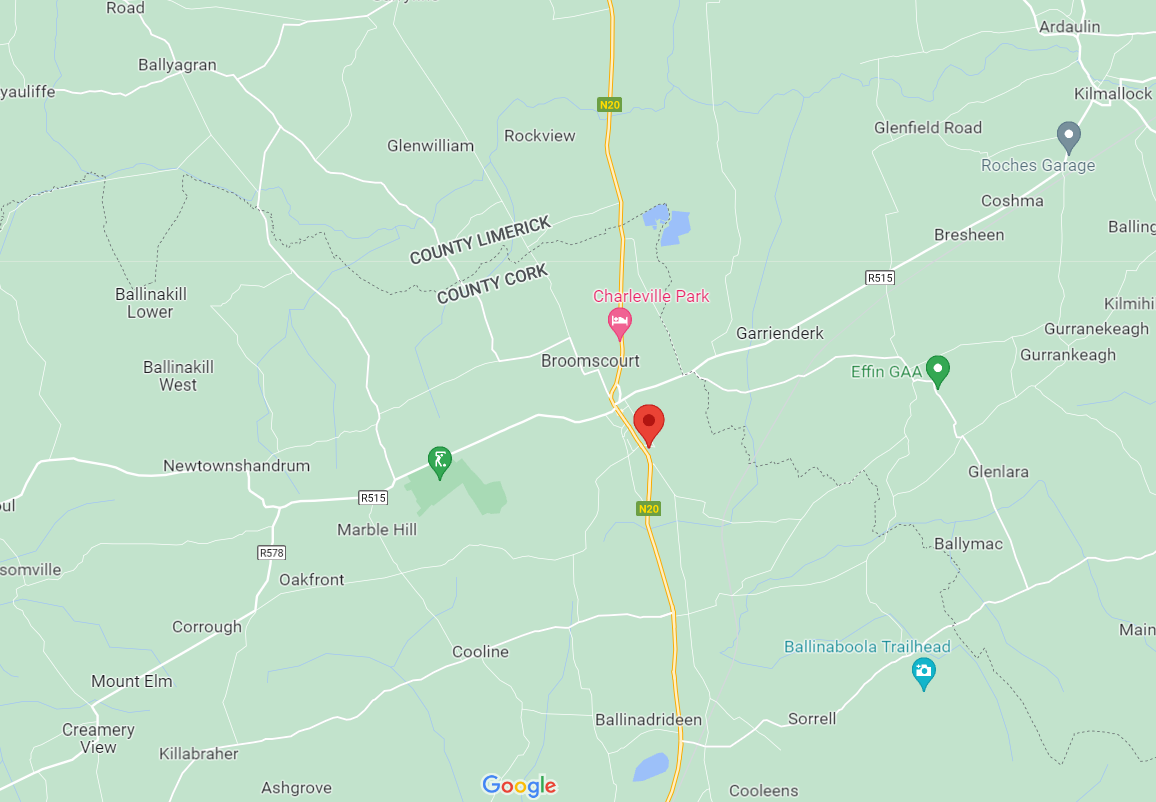

Four GPS parameters (latitude, longitude, altitude and reciever clock offset) can be obtained with using 4 satellite signals. 

The Newtonian method was used to approximate the location. Newton's method takes an initial location guess, and computes the differiential at this initial point. Using the differential a more accurate location guess is computed. This continues until the guess and the location are identical. 

For this calculation the Newtonian algorithm was run 10 of times. The result gets closer to the exact location with every loop. The further away the initial guess is from the exact location, the more amount of times the algorithm needs to run. Using Dublin as the initial guess; the algorithm converges after 4 runs (to the degree of accuracy suggested in the assignment). Using Indonesia as the inital guess; the algorithm converages after 5 runs (as demonstrated below). However, the difference between these positions is only 0.000001 degrees longitude! Therefore, the initial guess has little effect on the algorithms converage rate depending on the degree of accuracy that the user wants to achieve. 

In [10]:
xin, yin, zin = polar2cart(0.328986, 115.683953, 3671000)
Indonesia = [xin,  yin, zin, 10]

print("Indonesia's calculatiion after 4 runs:\n")
print_location(run_algorithm(Indonesia, 4))
print("Dublin's calculation after 4 runs:\n")
print_location(run_algorithm(initial_guesses, 4))

Indonesia's calculatiion after 4 runs:

Calculated latitude and longitude: 
52.349641, -8.676254 degrees 
Calculated Elevation = 78.41 metres 
Calculated receiver clock offset = -1642.00 microseconds 

Dublin's calculation after 4 runs:

Calculated latitude and longitude: 
52.349641, -8.676253 degrees 
Calculated Elevation = 78.17 metres 
Calculated receiver clock offset = -1642.00 microseconds 

